# Setup Preamble



In [1]:
import os
import logging

# Scientific libraries
import pandas as pd
from Bio import SeqIO

# Graphic libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# other imports
import ete3
from FastOMA._utils_roothog import parse_proteomes
from FastOMA.zoo.hog import extract_hog_info
from FastOMA._wrappers import logger
logger.setLevel(logging.INFO)

In [2]:
# Extra options
pd.set_option('max_colwidth',200)
pd.options.display.max_rows = 150

#style options
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12.0, 8.0)

#seaborn options
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale=1.5)
sns.set_style('whitegrid')
palette="husl"

In [3]:
output_folder = "Output"
input_folder = "testdata/in_folder"
proteome_folder = input_folder + "/proteome"

In [4]:
# Parameters
output_folder = "./"
proteome_folder = "proteome"


# Stats on input dataset

## Proteomes 

We first show some statistics on the input proteomes, e.g. size distributions, length distributions etc, which can indicate problems in annotations and raise further problems in downstream analyses.

In [5]:
def get_protein_dataframe(folder):
    species, seq_reqs, _ = parse_proteomes(folder)
    print(f"There are {len(species)} species in the proteome folder.")
    print(f"In total, {sum(len(z) for z in seq_reqs.values())} proteins are in the dataset.")
    print("\nThe list of species is the following:")
    prot_df = []
    for sp in species:
        print(f" - {sp} (with {len(seq_reqs[sp])} proteins)")
        sp_df = pd.DataFrame({"prot_len": [len(z) for z in seq_reqs[sp]], "species": [sp for _ in range(len(seq_reqs[sp]))]})
        prot_df.append(sp_df)
    return pd.concat(prot_df)

protein_df = get_protein_dataframe(proteome_folder)

2024-08-23 00:55:01 INFO     There are 5 species in the proteome folder.


There are 5 species in the proteome folder.
In total, 1717 proteins are in the dataset.

The list of species is the following:
 - Neosartorya_fumigata (with 325 proteins)
 - Saccharomyces_cerevisiae (with 308 proteins)
 - Schizosaccharomyces_pombe (with 326 proteins)
 - Sclerotinia_sclerotiorum (with 433 proteins)
 - Yarrowia_lipolytica (with 325 proteins)


Next follows a visual overview of the size distribution of all these proteomes.

Text(0.5, 1.0, 'Distribution of number of proteins per species')

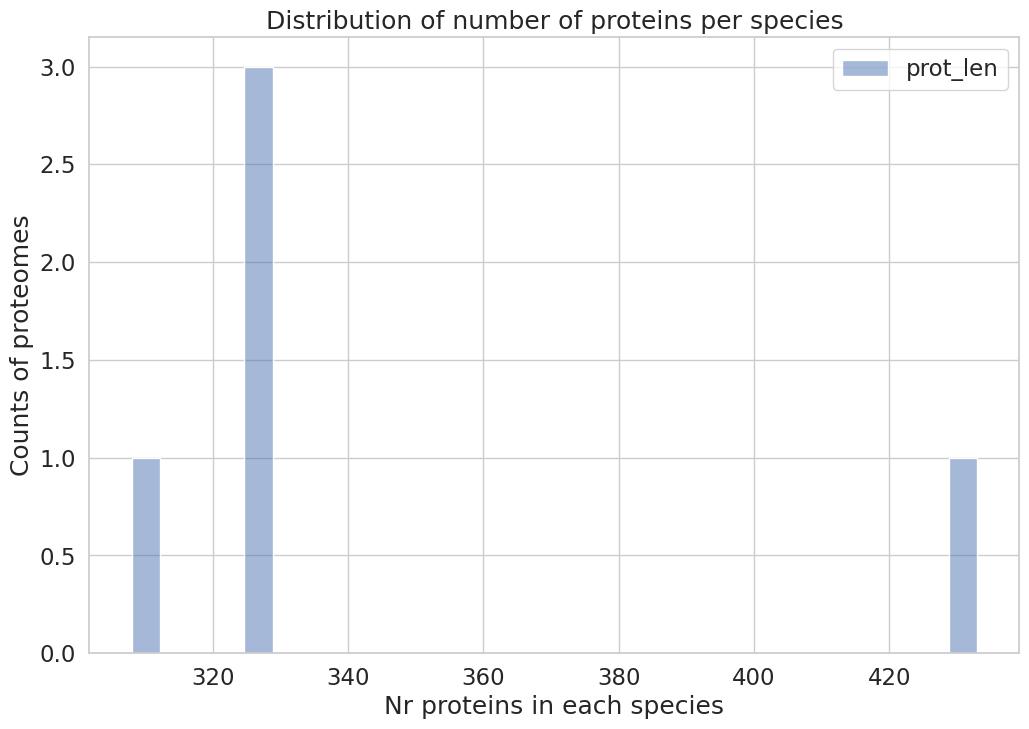

In [6]:
sns.histplot(data=protein_df.groupby("species", as_index=False).count(), stat="count", bins=30)
plt.xlabel("Nr proteins in each species")
plt.ylabel("Counts of proteomes")
plt.title("Distribution of number of proteins per species")

Text(0.5, 1.0, 'Number of proteins per genome')

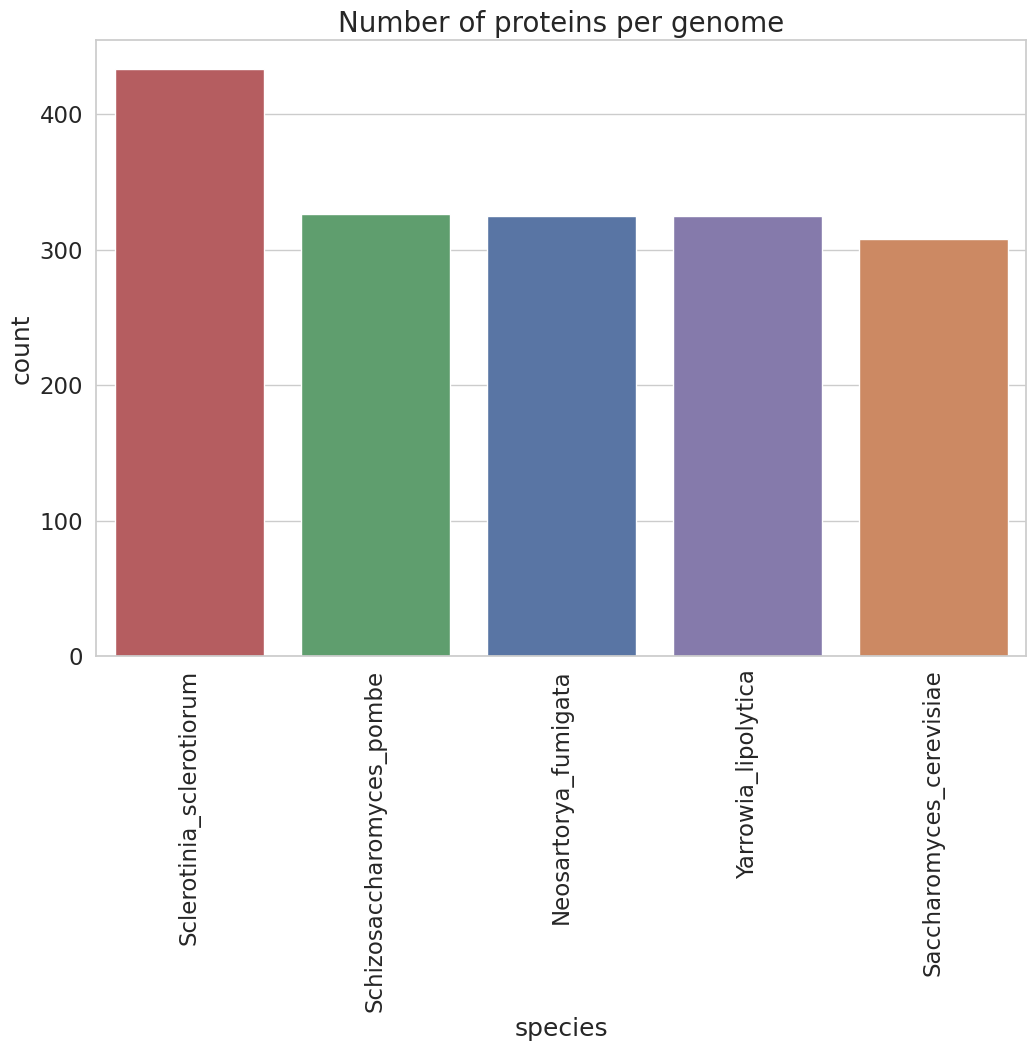

In [7]:
ax = sns.countplot(x="species", data=protein_df, 
                   order = protein_df['species'].value_counts().index,
                   hue = "species")
plt.xticks(rotation=90)
plt.title("Number of proteins per genome", fontsize=20)

Furthermore, a high proportion of proteins short in length may indicated a problem with genome quality. Below, we report the protein length distribution of all species used in this run. Suspect genomes are outlier peaks with a high number of short proteins.

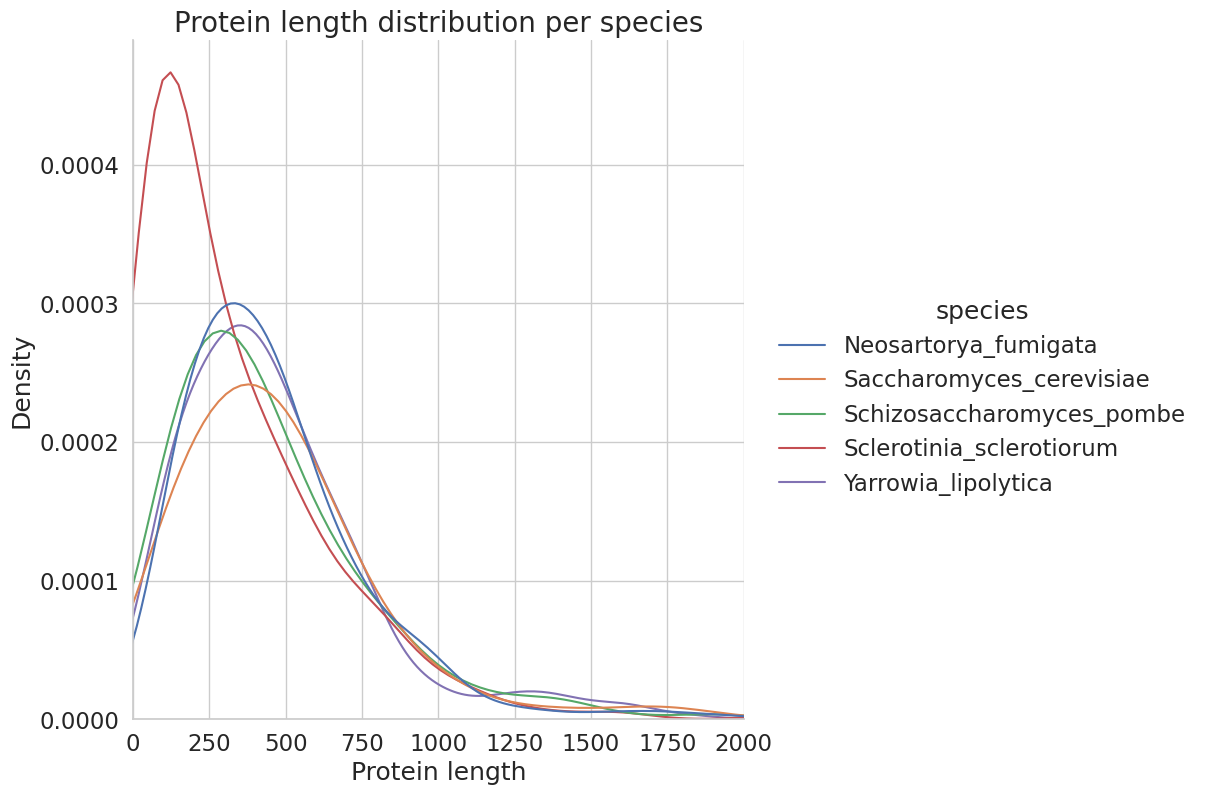

In [8]:
species_list = list(set(protein_df["species"]))
if len(species_list)<100:
    sns.displot(protein_df, x="prot_len", hue="species", kind="kde", height=8)
    plt.xlim(0, 2000)
    plt.title("Protein length distribution per species", fontsize=20)
    plt.xlabel("Protein length")


## Species tree 

Next, we look at the species input species tree. Note that errors in it can lead to wrong ortholog / paralog inference. FastOMA has identified on every internal level the set of orthologous groups in a hierarchically nested way, the Hierarchcial Orthologous Groups (HOGs).
With tools such as pyHAM you can extract the group memebers in a programmable way for any internal level of the below species tree.

In [9]:
species_tree = ete3.Tree(os.path.join(output_folder, "species_tree_checked.nwk"),format=1)
num_leaves = 0
num_internal = 0
for node in species_tree.traverse(strategy="postorder"):
    if node.is_leaf():
        num_leaves += 1
    else:
        num_internal += 1
print(f"There are {num_internal} taxonomic levels in the input species tree with {num_leaves} species as leaves.")

print(species_tree.get_ascii(show_internal=True))

There are 4 taxonomic levels in the input species tree with 5 species as leaves.

                                         /-Yarrowia_lipolytica
                        /Saccharomycetales
                       |                 \-Saccharomyces_cerevisiae
          /Saccharomyceta
         |             |            /-Neosartorya_fumigata
-Ascomycota             \Leotiomyceta
         |                          \-Sclerotinia_sclerotiorum
         |
          \-Schizosaccharomyces_pombe


# Stats on Orthoxml

In [10]:
hog_file = os.path.join(output_folder, "FastOMA_HOGs.orthoxml")
genome_coverage_stats = extract_hog_info.SpeciesAnalyser()
with open(hog_file, 'rt') as xml:
    hog_df = pd.DataFrame.from_records(extract_hog_info.parse_orthoxml(xml, genome_coverage_stats))
hog_summary_df = pd.DataFrame.from_records(genome_coverage_stats.summary())
df_seq = pd.merge(hog_summary_df, protein_df.groupby("species", as_index=False).count(), on='species')
df_seq['minor_splice'] = df_seq['prot_len']-df_seq['genes']
df_seq = df_seq[['species', 'genes', 'not_in_group','minor_splice']]
order = species_tree.get_leaf_names()
df_seq = df_seq.sort_values(by=['species'], key=lambda s: s.apply(order.index)).set_index('species')
df_seq

2024-08-23 00:55:03 INFO     start mapping of orthoxml formatted input file


,genes,not_in_group,minor_splice
species,,,
Yarrowia_lipolytica,325,270,0
Saccharomyces_cerevisiae,308,259,0
Neosartorya_fumigata,325,272,0
Sclerotinia_sclerotiorum,433,393,0
Schizosaccharomyces_pombe,326,277,0


## Genes in HOGs

First, let's check the fraction of genes that are in any HOG per species. Note that OMA will only use one isoform per gene (if properly annotated). The toal barchart height will indicated the total number of proteins in the fasta input file. The blue part (genes) is the number of genes that are in a HOG. 

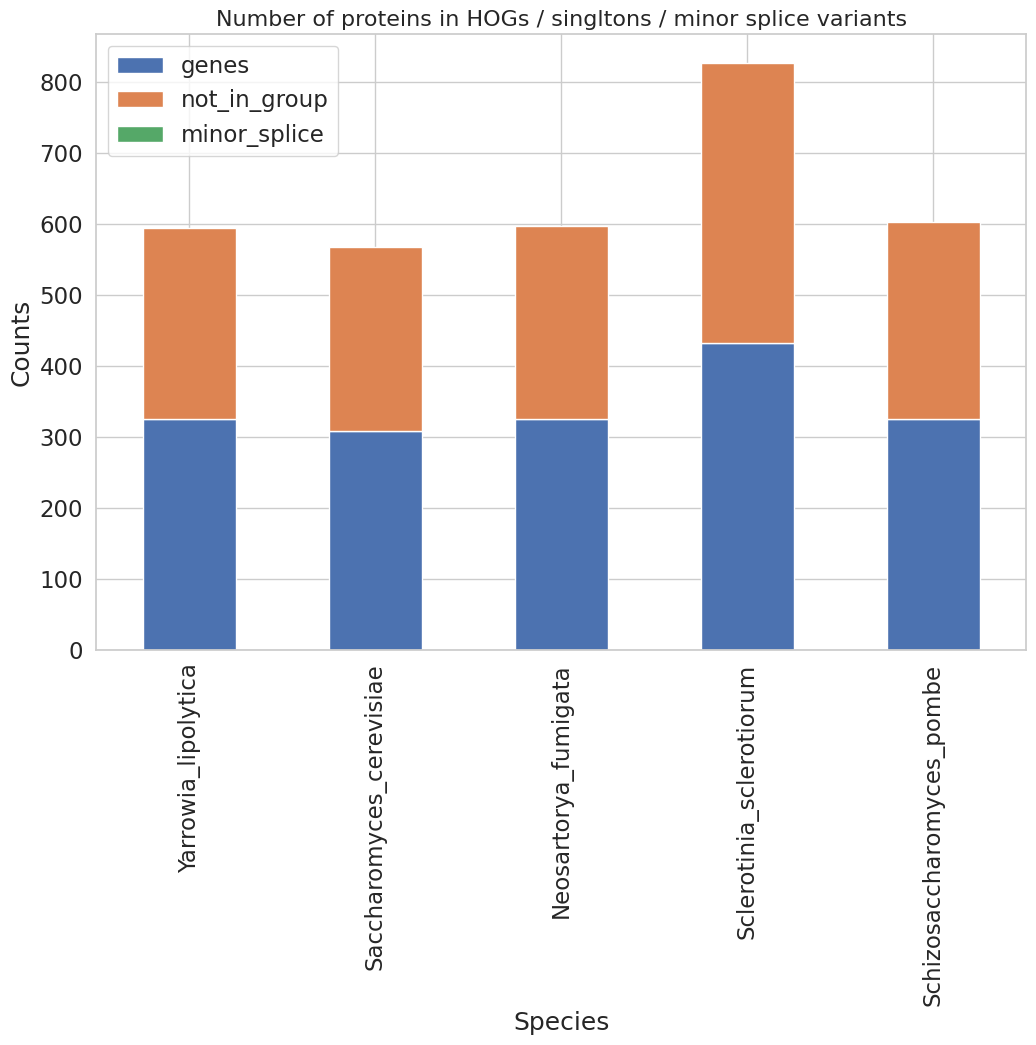

In [11]:
df_seq.plot(kind='bar', stacked=True)
plt.title('Number of proteins in HOGs / singltons / minor splice variants', fontsize=16)
plt.xlabel('Species')
plt.ylabel('Counts')
plt.xticks(rotation=90);

## Group sizes

As HOGs are nested groups, we first look at the rootlevel HOGs, so the deepest level of each HOG. The level itself can be at any of the internal taxonomic levels

In [12]:
hog_df

,id,level,CompletenessScore,nr_members,is_roothog
0,HOG:0000001_3,Saccharomycetales,1.0000,2,False
1,HOG:0000001_1,Ascomycota,0.6000,3,True
2,HOG:0000002_1,Ascomycota,NaN,2,True
3,HOG:0000003.1a_2,Saccharomyceta,0.5000,2,False
4,HOG:0000003.1b_3,Saccharomycetales,1.0000,2,False
5,HOG:0000003.1b_2,Saccharomyceta,0.7500,3,False
6,HOG:0000003_1,Ascomycota,NaN,5,True
7,HOG:0000004_1,Ascomycota,NaN,2,True
8,HOG:0000005_1,Ascomycota,NaN,2,True
9,HOG:0000006_1,Ascomycota,0.6000,5,True


Now, we can slice the HOGs in various ways. Remember, they are nested, so it usually makes sense to analyse either all the HOGs at their root level or alternativly look at a specific taxonomic level.

## Roothogs (deepest levels for every HOG)

Here, we first look at the all the RootHOGs. We can select them using the `is_roothog` column

In [13]:
roothog_df = hog_df[(hog_df['is_roothog']==True)]
print(f"Number of RootHOGs: {len(roothog_df)}")
roothog_df.describe()

Number of RootHOGs: 103


,CompletenessScore,nr_members
count,98.000000,103.000000
mean,0.961736,2.388350
std,0.126094,0.877083
min,0.400000,2.000000
25%,1.000000,2.000000
50%,1.000000,2.000000
75%,1.000000,2.000000
max,1.000000,7.000000


We can further analyse how complete these roothogs are. The `CompletenessScore` contains the fraction of species that have at least one gene in the HOG. 

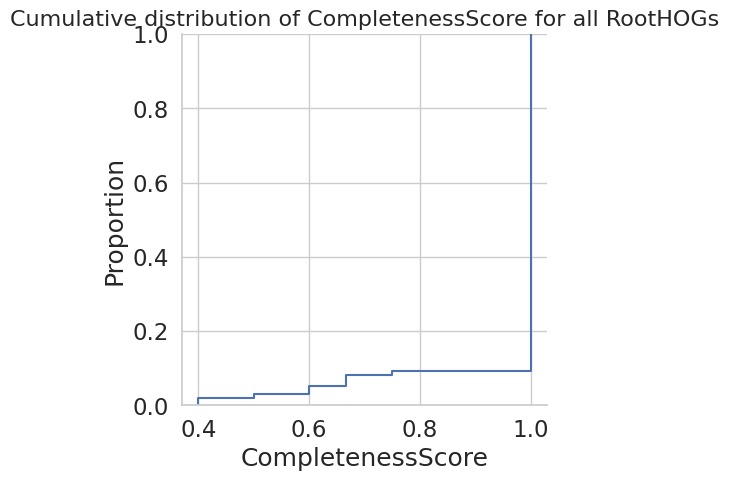

In [14]:
sns.displot(roothog_df, x="CompletenessScore", kind="ecdf")
plt.title("Cumulative distribution of CompletenessScore for all RootHOGs", fontsize=16);


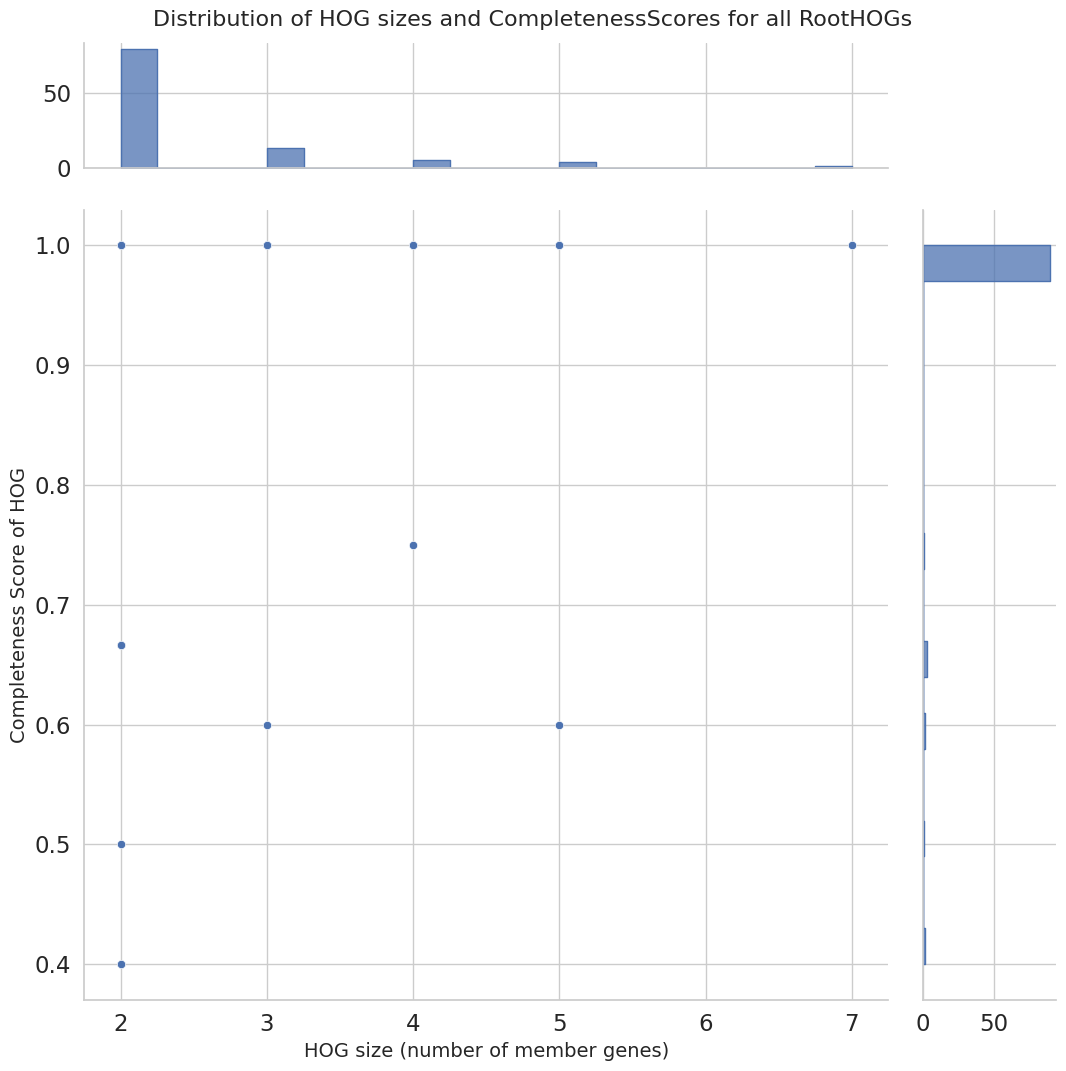

In [15]:
g = sns.jointplot(data=roothog_df, 
                  kind="scatter",
                  x='nr_members', 
                  y='CompletenessScore', 
                  marginal_kws=dict(bins=20, element="step"), 
                  marginal_ticks=True,
                  height=11)
g.fig.suptitle("Distribution of HOG sizes and CompletenessScores for all RootHOGs", fontsize=16)
g.ax_joint.set_xlabel("HOG size (number of member genes)", fontsize=14) 
g.ax_joint.set_ylabel("Completeness Score of HOG", fontsize=14)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

Alternatively, we can also analyse the HOGs at a given taxonomic level. Here, we generate the plot for a relatively deep level in the species tree. You can change this to more useful levels tfor your dataset.

## HOGs at a taxonomic level

In [16]:
desired_subtree_size = max(2, int(0.4*len(species_tree.get_leaf_names())))
node = species_tree
while True:
    nr_child = [len(c.get_leaves()) for c in node.get_descendants()]
    if max(nr_child) < desired_subtree_size:
        break
    k = nr_child.index(max(nr_child))
    node = node.get_descendants()[k]
level = node.name
print(f"We've selected {level} as our level of interest\nIt contains {len(node.get_leaf_names())} species (out of {len(species_tree.get_leaves())}).\nYou can use a different level by setting the level variable in the next cell instead.")

We've selected Saccharomycetales as our level of interest
It contains 2 species (out of 5).
You can use a different level by setting the level variable in the next cell instead.


In [17]:
#level = "XXX"

In [18]:
level_df = hog_df[(hog_df['level']==level)]
print(f"Number of HOGs at {level}: {len(level_df)}")
level_df.describe()

Number of HOGs at Saccharomycetales: 15


,CompletenessScore,nr_members
count,15.0,15.000000
mean,1.0,2.066667
std,0.0,0.258199
min,1.0,2.000000
25%,1.0,2.000000
50%,1.0,2.000000
75%,1.0,2.000000
max,1.0,3.000000


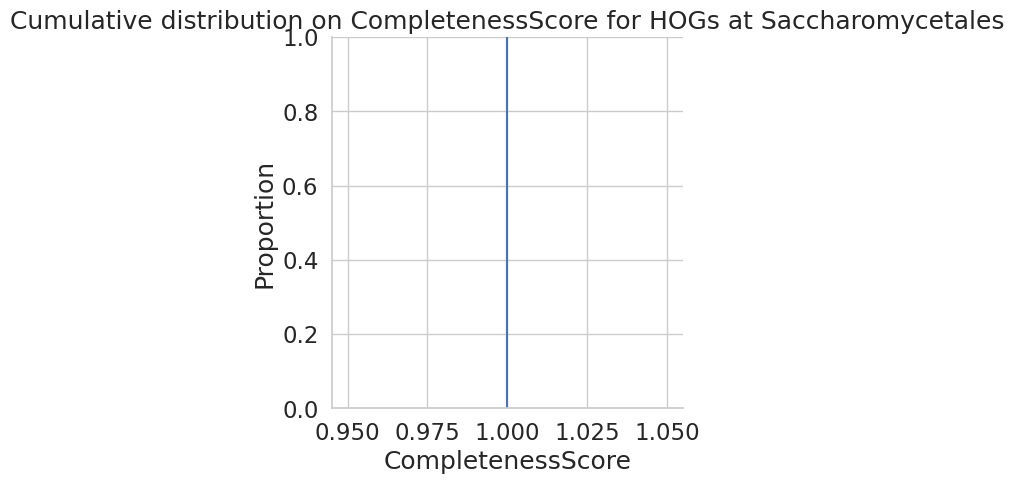

In [19]:
sns.displot(level_df, x="CompletenessScore", kind="ecdf")
plt.title(f"Cumulative distribution on CompletenessScore for HOGs at {level}");


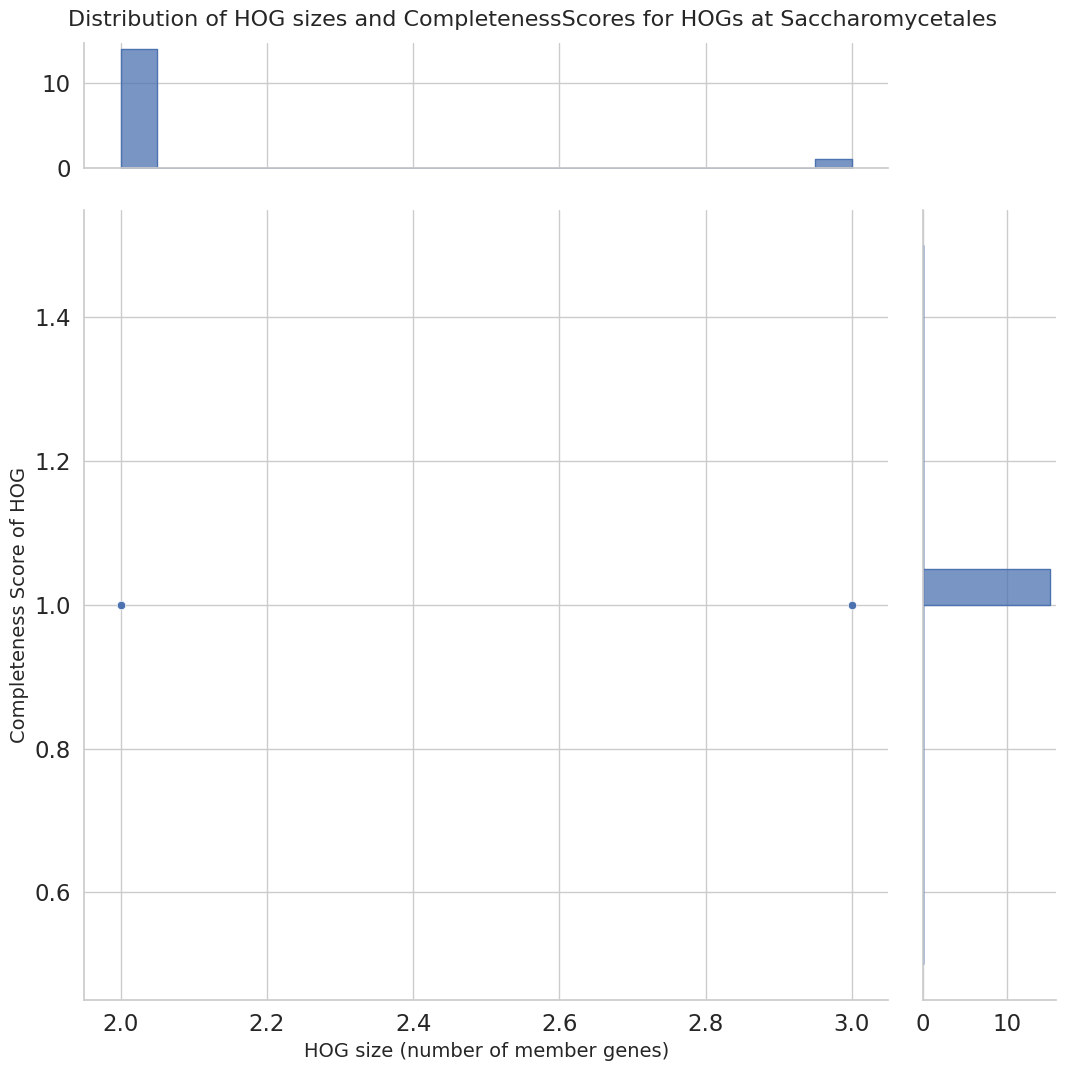

In [20]:
g = sns.jointplot(data=level_df, 
              kind="scatter",
              x='nr_members', 
              y='CompletenessScore', 
              marginal_kws=dict(bins=20, element="step"), 
              marginal_ticks=True,
              height=11)
g.fig.suptitle(f"Distribution of HOG sizes and CompletenessScores for HOGs at {level}", fontsize=16)
g.ax_joint.set_xlabel("HOG size (number of member genes)", fontsize=14) 
g.ax_joint.set_ylabel("Completeness Score of HOG", fontsize=14)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95) 

# Get duplications/losses/gains/retained with PyHAM

In [21]:
import pyham       
import logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(name)-12s %(levelname)-8s %(message)s")

In [22]:
nwk_path= os.path.join(output_folder, "species_tree_checked.nwk") # species tree should be pruned (no extra leaves)
orthoxml_path=os.path.join(output_folder, "FastOMA_HOGs.orthoxml")
ham_analysis = pyham.Ham(nwk_path, orthoxml_path, tree_format="newick", use_internal_name=True)
print("Ham analysis done") # for a big orthoxml file it can take ~30mins

2024-08-23 00:55:05 INFO     Build taxonomy: completed.


2024-08-23 00:55:05 INFO     Species Neosartorya_fumigata created. 


2024-08-23 00:55:05 INFO     Species Saccharomyces_cerevisiae created. 


2024-08-23 00:55:05 INFO     Species Schizosaccharomyces_pombe created. 


2024-08-23 00:55:05 INFO     Species Sclerotinia_sclerotiorum created. 


2024-08-23 00:55:05 INFO     Species Yarrowia_lipolytica created. 


2024-08-23 00:55:05 INFO     Parse Orthoxml: 103 top level hogs and 1717 extant genes extract.


2024-08-23 00:55:05 INFO     Set up Ham analysis: ready to go with 103 hogs founded within 5 species.


Ham analysis done


## Generate Phylostratigraphy plots

create tree profile, classify all genomes by extant or ancestral, and get % of dup, lost, retained, and gained

In [23]:
phylostratigraphy = os.path.join(output_folder, "phylostratigraphy.html")
treeprofile = ham_analysis.create_tree_profile(outfile=phylostratigraphy)

from IPython.display import IFrame
IFrame(os.path.basename(phylostratigraphy), width=800, height=600)